# Kinect 2D to 3D

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import warnings
warnings.simplefilter('ignore')

In [4]:
datasetPath = '../../datasets/kinect_good_preprocessed_not_cut/'

X = None
y = pd.DataFrame()

train_test_ratio = 0.8
random_state = 47

# Model parameters
units = 64
activation = 'relu'
output_layer = ''
output_size = 13
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = 'mse'
metrics = ['mae']
epochs = 500
batch_size = 16

# Early stopping parameters
monitor = 'val_loss'
verbose = 1
patience = 20
mode = 'min'
restore_best_weights = True

In [3]:
np.random.seed(random_state)

## 1. Data Preparation

Loading files and separating between (X,Y) and Z.

In [5]:
import re

for file in os.listdir(datasetPath):
    if file.endswith('.csv'):
        try:
            dataset = pd.read_csv(datasetPath + file)
            dataset.drop(columns=['FrameNo'], inplace=True)

            # Separate (X,Y) and Z
            z = []
            temp = pd.DataFrame()
            for c in dataset.columns:
                if re.search("^.*_z$", c):
                    temp[c] = dataset[c]
                    dataset.drop(columns=[c], inplace=True)
            
            if X is None:
                X = dataset
            else:
                X = pd.concat((X, dataset), ignore_index=True)

            if y is None:
                y = temp
            else: 
                y = pd.concat((y, temp), ignore_index=True)

        except IOError as e:
            print('Error in reading file: ', e)

print(X.shape)
print(y.shape)

(38027, 26)
(38027, 13)


### Training and test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=train_test_ratio, random_state=random_state)

input_dim = X_train.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30421, 26)
(30421, 13)
(7606, 26)
(7606, 13)


### Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-3.59032211e-01,  6.96528987e-01, -5.11276014e-01, ...,
        -1.30349510e+00,  4.41456546e-01, -9.46575280e-01],
       [ 5.74317079e+00,  6.11765083e-01,  5.83312770e+00, ...,
         1.67530897e+00,  6.15834775e+00,  7.79138417e-01],
       [ 4.64175045e-01,  1.02739831e+00,  2.65186818e-01, ...,
        -1.10418907e-01,  4.35548519e-01, -4.35416037e-01],
       ...,
       [-1.00618314e-01,  7.43779001e-01, -1.18342939e-02, ...,
         7.44592412e-01, -5.74067619e-01,  6.21681324e-01],
       [-1.87081943e-01, -1.03546819e+00,  5.70940378e-04, ...,
         9.00687878e-01, -3.54704771e-01,  1.00946076e+00],
       [-3.14377557e-01,  4.12313591e-01, -4.73274064e-01, ...,
         1.35002135e+00, -1.10873310e+00,  1.42319906e+00]])

## 2. DL Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

model = Sequential([
    InputLayer(input_shape=(input_dim))
])
model.add(Dense(units=units, activation=activation))
model.add(Dense(units=units, activation=activation))
if not output_layer:
    model.add(Dense(units=output_size))
else:
    model.add(Dense(units=output_size, activation=output_layer))

optimizer = tf.keras.optimizers.get(optimizer)
optimizer.learning_rate.assign(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1728      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 13)                845       
Total params: 6,733
Trainable params: 6,733
Non-trainable params: 0
_________________________________________________________________


### Early stopping

In [9]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor=monitor, 
    verbose=verbose,
    patience=patience,
    mode=mode,
    restore_best_weights=restore_best_weights)

### Model Training

In [10]:
history = model.fit(x=X_train, y=y_train, validation_split=0.2, shuffle=True, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=[early_stopping])

training_history = pd.DataFrame(history.history)
training_history['epochs'] = range(len(training_history['mae']))

Epoch 1/500
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0077 - mae: 0.0594 - val_loss: 0.0036 - val_mae: 0.0415
Epoch 2/500
1521/1521 [==============================] - 1s 806us/step - loss: 0.0037 - mae: 0.0421 - val_loss: 0.0031 - val_mae: 0.0388
Epoch 3/500
1521/1521 [==============================] - 1s 882us/step - loss: 0.0031 - mae: 0.0385 - val_loss: 0.0027 - val_mae: 0.0363
Epoch 4/500
1521/1521 [==============================] - 1s 949us/step - loss: 0.0027 - mae: 0.0363 - val_loss: 0.0024 - val_mae: 0.0338
Epoch 5/500
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0024 - mae: 0.0342 - val_loss: 0.0026 - val_mae: 0.0357
Epoch 6/500
1521/1521 [==============================] - 2s 1ms/step - loss: 0.0022 - mae: 0.0328 - val_loss: 0.0022 - val_mae: 0.0328
Epoch 7/500
1521/1521 [==============================] - 1s 913us/step - loss: 0.0020 - mae: 0.0311 - val_loss: 0.0020 - val_mae: 0.0316
Epoch 8/500
1521/1521 [========================

### Plot training and validation MAE & loss per epoch

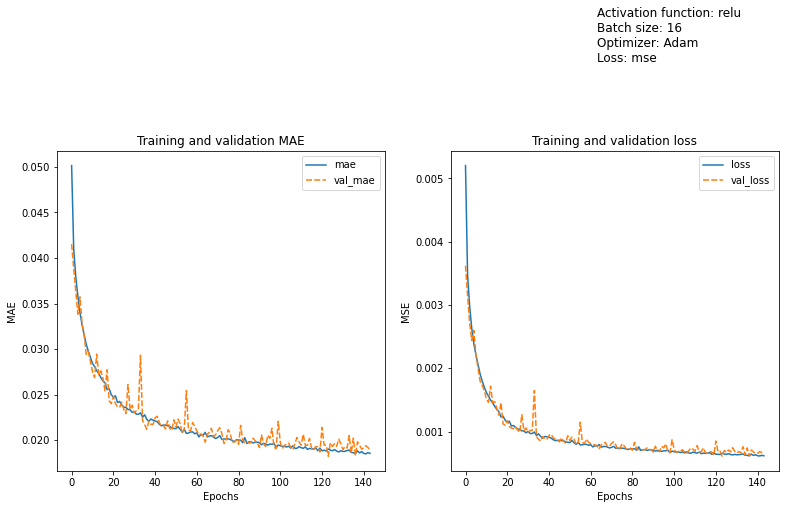

In [11]:
plots = [
           {'cols':['mae', 'val_mae'], 'title':'Training and validation MAE', 'yLabel':'MAE'},
           {'cols':['loss', 'val_loss'], 'title':'Training and validation loss', 'yLabel':'MSE'},
]

fig = plt.figure(figsize=(20,20))
fig_no = 331
title = 'Activation function: {}\nBatch size: {}\nOptimizer: {}\nLoss: {}'.format(activation, batch_size,optimizer._name, loss)
fig.suptitle(title, fontsize="large", horizontalalignment='left', verticalalignment='top')

for i in range(len(plots)):
    ax = fig.add_subplot(str(fig_no))
    sns.lineplot(data=training_history[plots[i]['cols']], ax=ax)
    plt.title(plots[i]['title'])
    plt.xlabel('Epochs')
    plt.ylabel(plots[i]['yLabel'])
    fig_no += 1

plt.show()

### Predictions

In [12]:
predictions = model.predict(x=X_test, verbose=1)

238/238 [==============================] - 0s 455us/step


In [13]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

print('MSE: ', mean_squared_error( y_test, predictions ))
print('MSA: ', mean_absolute_error( y_test, predictions ))
print('R-Squared: ', r2_score( y_test, predictions ))
print('Explained Variance Score: ', explained_variance_score( y_test, predictions ))

MSE:  0.0006160947074422262
MSA:  0.01829777036812893
R-Squared:  0.9706450899311778
Explained Variance Score:  0.9710333563211575
